# Data Science In One* Hour: Edge Detection
\**for sufficiently large values of one*

**Tom Darby**  
**Data Science**  
**Spring 2020** 
**Assignment 1**  

For our first assignment, I've decided to write a very simple edge-detection algorithm for analyzing arbitrary images. It's not a particularly complicated implementation, but it's something I can put together in a short time fairly easily.

This entire exercise took a few hours to complete, as it included getting my environment on tensor.hood.edu up and running, familiarizing myself with Jupyter notebooks, some light research on which libraries I'd want to use, and shifting mental gears from C# syntax (where I spend most of my time) to Python syntax (where I know what's going on but have considerably less experience than other languages.) While the guts of the algorithm took right around an hour, additional time was spent debugging, improving, and documenting this notebook.

Stack Exchange helped considerably in the completion of this exercise.

## Supporting Libraries

I'll be using the Computer Vision library (cv2) to load images, as image loading isn't the interesting part of what I'll be doing today. 

To install cv2, run:

        conda install -c anaconda opencv
        
We'll also be using pyplot to show images in this notebook.

In [1]:
import numpy as np
import cv2
import urllib
from matplotlib import pyplot as plt



## User Options

In the following block of code, there are options you can adjust to change how this script works. 

The `deltaThreshold` value allows you to adjust the sensitivity of the edge detection algorithm. Simply put, if the  value of the current pixel is `deltaThreshold` more or less than that of the previous pixel, that pixel is marked as an edge pixel. Trial and error has shown 14 to be a generally good value for a variety of applications.

the `pixelAdjustment` value defines what type of interpolation to apply to plotted images. Since this notebook's output is smaller than most of our source images, I've gone with `bilinear` interpolation as the default; this setting generates output pixels that are representative of the averages of multiple source pixels. The other recommended setting, `nearest` neighbor, uses a single pixel out of a group of source pixels to set the output pixel's value.

Nearest neighbor will result in brighter, choppier edges that may not convey all edge data; bilinear will result in fainter but more accurate edge representations.

In [2]:
deltaThreshold = 12

#pixelAdjustment = 'nearest'
pixelAdjustment = 'bilinear'


## Dataset

My dataset will be an image from the Internet. Specifically, I'll be using a photo of my dog, Latte. I've provided a few other examples from a variety of sources, as well; uncomment different `urllib.request.urlopen` lines below to change the image, or enter your own at the bottom.

In [3]:
# a photo of my dog with strong edges
loadedRawData = urllib.request.urlopen('https://pbs.twimg.com/media/ENn1JwVXkAcpNjY?format=jpg&name=4096x4096').read()

############################
##### ALTERNATE IMAGES #####
############################

# a photo of my dog with weak edges
#loadedRawData = urllib.request.urlopen('https://pbs.twimg.com/media/EO5jMShXsAM5sMZ?format=jpg&name=4096x4096').read()

# Saturn V liftoff
#loadedRawData = urllib.request.urlopen('https://www.nasa.gov/sites/default/files/styles/side_image/public/62295main_liftoff_full.jpg?itok=3qa1O7vU').read()

# the Google Logo: an outstanding source for edge detection
#loadedRawData = urllib.request.urlopen('https://cdn.vox-cdn.com/thumbor/Pkmq1nm3skO0-j693JTMd7RL0Zk=/0x0:2012x1341/1200x800/filters:focal(0x0:2012x1341)/cdn.vox-cdn.com/uploads/chorus_image/image/47070706/google2.0.0.jpg').read()

# "Starry Night": a sub-optimal source for edge detection
#loadedRawData = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg').read()

# Choose your own image:
#loadedRawData = urllib.request.urlopen('{URL GOES HERE}').read()

Once I've loaded an image, I convert the loaded data into a cv2 image. I'll also convert to greyscale at this point to reduce dimensionality and make the data easier to work with.

*Note that I'm doing a weird back-conversion from color to grayscale and back again. This lets us add edge data to the source image later; it also makes cv2 play nicely with the plotting library. There's some channel weirdness going on that I can fix with an ugly kludge easily enough, so.*

*Note, too, that I'm using bilinear interpolation when displaying photos. I'm not good enough with Python and matplotlib yet to know how to easily resize these outputs, so I've turned on bilinear interpolation to ensure that all the edge data is at least visible in the outputs. With the default "nearest neighbor" interpolation, a lot of data points were being dropped, resulting in choppier-looking results that left out key bits of data.*

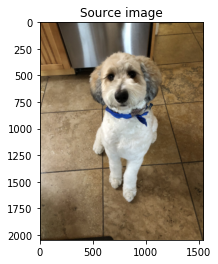

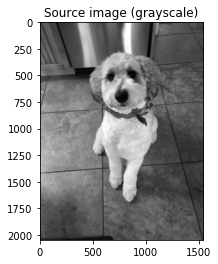

In [4]:
sourceImage = np.asarray(bytearray(loadedRawData), dtype="uint8")

sourceImageColor = cv2.imdecode(sourceImage, cv2.COLOR_BGR2RGB)
sourceImage = cv2.cvtColor(sourceImageColor, cv2.COLOR_RGB2GRAY)
sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_GRAY2RGB)

sourceImageColor = cv2.cvtColor(sourceImageColor, cv2.COLOR_BGR2RGB)


plt.imshow(sourceImageColor, interpolation=pixelAdjustment)
plt.title("Source image")
plt.show()
plt.imshow(sourceImage, interpolation=pixelAdjustment)
plt.title("Source image (grayscale)")
plt.show()

We can use cv2's *shape* property to find the dimensions of the image, like so:

In [5]:
print("Loaded image dimensions: " + str(sourceImage.shape[0]) + "x" + str(sourceImage.shape[1]))


Loaded image dimensions: 2048x1536


## Basic Edge Detection

Now that we've loaded the image into an array of greyscale values, we can begin performing edge detection. First, we'll create a clone of the image to use as our destination image.

In [6]:
targetImage = np.asarray(bytearray(loadedRawData), dtype="uint8")
targetImage = cv2.imdecode(targetImage, cv2.COLOR_BGR2GRAY)
print("target image created: " + str(targetImage.shape[0]) + "x" + str(targetImage.shape[1]))

target image created: 2048x1536


Then, we get to our edge detection algorithm. This is a simple matter of scanning through each row of pixels in the image and determining how much the value of the current pixel has changed from the value of the previous pixel we examined. If the difference in pixel values exceeds a certain threshold (indicated in `deltaThreshold`,) then we count that as an edge pixel.

I've added some supporting data structures that I may use in future to do things like automatically choose thresholds, but that doesn't happen in an hour.

maxPixelValue = 199, minPixelValue = 0
max occurrance count: 2976828.0


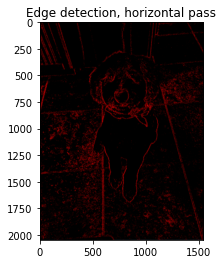

In [7]:
xMax = targetImage.shape[0]-1
yMax = targetImage.shape[1]-1




maxPixelValue = 0
minPixelValue = 255
pixelCounts = np.zeros(255)

xIndex = 0
yIndex = 0

previousPixel = 0

while(xIndex < xMax):
    yIndex = 0
    previousPixel = sourceImage[xIndex,yIndex,0];
    while (yIndex < yMax):
        delta = abs(int(previousPixel) - int(sourceImage[xIndex, yIndex,0]))
        maxPixelValue = max(delta, maxPixelValue)
        minPixelValue = min(delta, minPixelValue)
        if (delta < deltaThreshold):
            delta = 0
        else:
            delta = 254
        targetImage[xIndex, yIndex,0] = delta
        targetImage[xIndex, yIndex,1] = 0
        targetImage[xIndex, yIndex,2] = 0
        pixelCounts[delta] += 1

        previousPixel = sourceImage[xIndex,yIndex,0];
        yIndex += 1
    xIndex += 1

print("maxPixelValue = " + str(maxPixelValue) + ", minPixelValue = " + str(minPixelValue))
print("max occurrance count: " + str(np.max(pixelCounts)));

plt.imshow(targetImage, interpolation=pixelAdjustment)
plt.title("Edge detection, horizontal pass")
plt.show()




After I finish my row scan, I perform a column scan. Note that I'm simply adding to the thresholds calculated in my first pass. This will allow me to rapidly identify values that were found in both the horizontal and vertical passes.

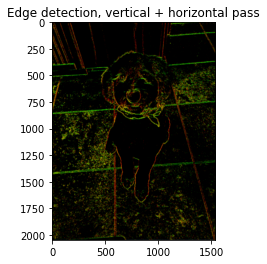

In [8]:

maxPixelValue = 0
minPixelValue = 255
pixelCounts = np.zeros(255)

xIndex = 0
yIndex = 0

previousPixel = 0

while(yIndex < yMax):
    xIndex = 0
    previousPixel = sourceImage[xIndex,yIndex,0];
    while (xIndex < xMax):
        delta = abs(int(previousPixel) - int(sourceImage[xIndex, yIndex,0]))
        maxPixelValue = max(delta, maxPixelValue)
        minPixelValue = min(delta, minPixelValue)
        if (delta < deltaThreshold):
            delta = 0
        else:
            delta = 254
        targetImage[xIndex, yIndex,0] += 0
        targetImage[xIndex, yIndex,1] += delta
        targetImage[xIndex, yIndex,2] += 0
        pixelCounts[delta] += 1

        previousPixel = sourceImage[xIndex,yIndex,0];
        xIndex += 1
    yIndex += 1

plt.imshow(targetImage, interpolation=pixelAdjustment)
plt.title("Edge detection, vertical + horizontal pass")
plt.show()



Having run both my horizontal and vertical pass, we can see the results of both passes on the same image. Green pixels indicate vertical pass hits, red pixels indicate horizontal pass hits, and yellow pixels indicate hits from both directions. By combining the two results, we get a pretty good edge detection result below:

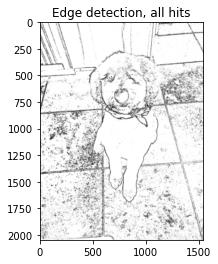

In [9]:
xIndex = 0
yIndex = 0

previousPixel = 0

while(xIndex < xMax):
    yIndex = 0
    while (yIndex < yMax):
        if ((int(targetImage[xIndex, yIndex, 0]) + int(targetImage[xIndex, yIndex, 1]) + int(targetImage[xIndex, yIndex, 2])) < 250):
            targetImage[xIndex, yIndex, 0] = 0
            targetImage[xIndex, yIndex, 1] = 0
            targetImage[xIndex, yIndex, 2] = 0
        else:
            targetImage[xIndex, yIndex, 0] = 254
            targetImage[xIndex, yIndex, 1] = 254
            targetImage[xIndex, yIndex, 2] = 254
        yIndex += 1
    xIndex += 1
    
# invert the image to make it look better
targetImage = cv2.bitwise_not(targetImage)

plt.imshow(targetImage, interpolation=pixelAdjustment)
plt.title("Edge detection, all hits")
plt.show()

# re-invert image for further processing below
targetImage = cv2.bitwise_not(targetImage)


Now, I can take my final basic edge detection and overlay it on top of the original color image. The algorithm clearly highlights edge features, but it also catches things like bold patterns, shadows and other noise. It's far from an optimal solution for edge detection, but it's a start.

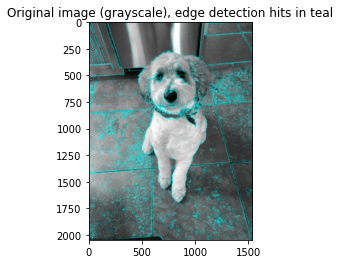

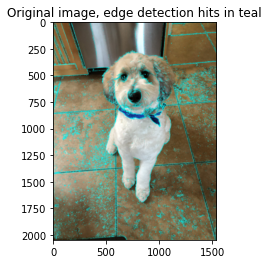

In [10]:
xIndex = 0
yIndex = 0

while(xIndex < xMax):
    yIndex = 0
    while (yIndex < yMax):
        if (targetImage[xIndex, yIndex, 0] > 200):
            sourceImage[xIndex, yIndex, 0] = 0
            sourceImage[xIndex, yIndex, 1] = 254
            sourceImage[xIndex, yIndex, 2] = 254
            sourceImageColor[xIndex, yIndex, 0] = 0
            sourceImageColor[xIndex, yIndex, 1] = 254
            sourceImageColor[xIndex, yIndex, 2] = 254
        yIndex += 1
    xIndex += 1
    
plt.imshow(sourceImage, interpolation=pixelAdjustment)
plt.title("Original image (grayscale), edge detection hits in teal")
plt.show()

plt.imshow(sourceImageColor, interpolation=pixelAdjustment)
plt.title("Original image, edge detection hits in teal")
plt.show()

## And that's it! 
That's my quick edge detection algorithm, all done in one* hour! Future work on this might include additional steps, such as are used in the Canny algorithm (which is where I drew initial inspiration for this exercise.) Things like Gaussian blurring, clustering, and line completion could all help build a much more powerful edge detector.

*\*margin of error ±400%*